In [8]:
INTERPOLATED_TAG = True

In [5]:
%load_ext autoreload
%autoreload 2

import os
import src.starter.utils as starter
import src.starter.visualize2 as vis2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook, tqdm
import numpy as np
import cv2
import matplotlib as mpl
from src.vis_utils import show_slices, multi_slice_viewer
tqdm.pandas()

def imshow(img, cmap=None):
#     plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
#     plt.show()

def find_first_kidney_slice(mask, plane='axial', with_last=False):
    plane_opts = ["axial", "coronal", "sagittal"]
    if plane not in plane_opts:
        raise ValueError((
            "Plane \"{}\" not understood. " 
            "Must be one of the following\n\n\t{}\n"
        ).format(plane, plane_opts))
    mask_data = mask.get_data()
    if plane == plane_opts[1]:
        mask_data = mask_data.transpose(1,0,2)
    if plane == plane_opts[2]:
        mask_data = mask_data.transpose(2,0,1)
    first_index = np.where(mask_data.sum(axis=(1,2))>0)[0][0]
    if not with_last:
        return first_index
    else:
        mask_data = np.flipud(mask_data)
        last_index = len(mask_data) - 1 - np.where(mask_data.sum(axis=(1,2))>0)[0][0]
        return first_index, last_index

data = pd.read_csv("data_interpolated_stats.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Problem Setting

(87, 615, 615)
(1421, 1021)


/home/ylochman/.conda/envs/py37/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


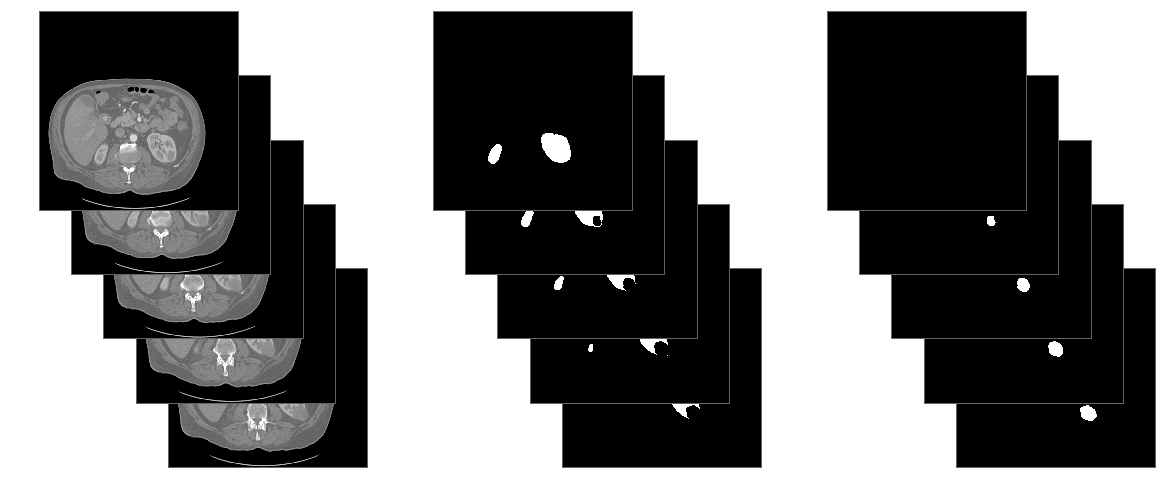

In [9]:
BORDER_SIZE = 3

def bordered(img):
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    img = cv2.copyMakeBorder(img, top=BORDER_SIZE, bottom=BORDER_SIZE, left=BORDER_SIZE, right=BORDER_SIZE,
                              borderType=cv2.BORDER_CONSTANT, value=(100,100,100)).mean(2)
    return img

%matplotlib inline
mpl.rcParams['figure.figsize'] = (20,20)
case_nid = 2
vol, seg = starter.load_case(case_nid, interpolated=INTERPOLATED_TAG)
index = find_first_kidney_slice(seg) + 37
vol = vol.get_fdata()
seg = seg.get_fdata()
print(vol.shape)
offset_bottom = 200
offset_right = 100
N = 4
tot_vol = np.ones((vol.shape[1]+offset_bottom*N+2*BORDER_SIZE,
                   vol.shape[1]+offset_right*N+2*BORDER_SIZE)) * 255
tot_seg1 = tot_vol.copy()
tot_seg2 = tot_vol.copy()
print(tot_vol.shape)
#     vol = ((vol - vol.min()) / (vol.max() - vol.min()) * 255).astype(np.uint8)
vol = vis2.hu_to_grayscale(vol, hu_min=-512, hu_max=512)[:,:,:,0]
for j in range(N,-1,-1):
    tot_vol[offset_bottom*j:vol.shape[1]+offset_bottom*j+2*BORDER_SIZE,
            offset_right*j:vol.shape[2]+offset_right*j+2*BORDER_SIZE] = bordered(vol[index+j])
    tot_seg1[offset_bottom*j:vol.shape[1]+offset_bottom*j+2*BORDER_SIZE,
             offset_right*j:vol.shape[2]+offset_right*j+2*BORDER_SIZE] = bordered((seg==1)[index+j].astype(np.uint8) * 255)
    tot_seg2[offset_bottom*j:vol.shape[1]+offset_bottom*j+2*BORDER_SIZE,
             offset_right*j:vol.shape[2]+offset_right*j+2*BORDER_SIZE] = bordered((seg==2)[index+j].astype(np.uint8) * 255)
    plt.subplot(1,3,1)
    imshow(vol[index+j], 'gray')
    plt.subplot(1,3,2)
    imshow((seg==1)[index+j], 'gray')
    plt.subplot(1,3,3)
    imshow((seg==2)[index+j], 'gray')
#         plt.show()

plt.subplot(1,3,1)
imshow(tot_vol, 'gray')
plt.subplot(1,3,2)
imshow(tot_seg1, 'gray')
plt.subplot(1,3,3)
imshow(tot_seg2, 'gray')
plt.show()

### Training data example

(101, 602, 602)


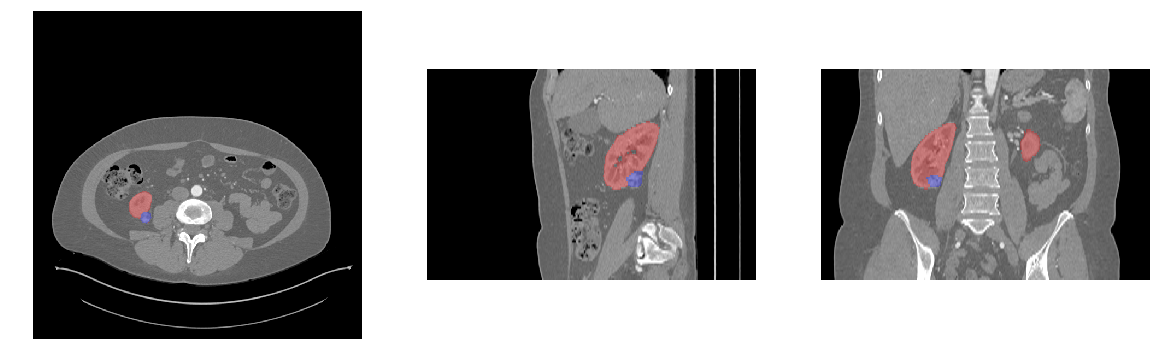

In [10]:
def show_three_planes(vol, seg):
    print(vol.get_fdata().shape)
    plt.subplot(1,3,1)
    overlayed = vis2.overlayed_images(vol, seg, plane='axial')
    imshow(overlayed[find_first_kidney_slice(seg) + 40])
    plt.subplot(1,3,2)
    overlayed = vis2.overlayed_images(vol, seg, plane='sagittal')
    imshow(overlayed[find_first_kidney_slice(seg, plane='sagittal') + 50])
    plt.subplot(1,3,3)
    overlayed = vis2.overlayed_images(vol, seg, plane='coronal')
    imshow(overlayed[find_first_kidney_slice(seg, plane='coronal') + 50])
    plt.show()
    

mpl.rcParams['figure.figsize'] = (20,20)
for i in range(9):
    vol, seg = starter.load_case(i, interpolated=INTERPOLATED_TAG)
    show_three_planes(vol, seg)
    break

### Mean location

In [3]:
# %matplotlib inline
mpl.rcParams['figure.figsize'] = (20,20)
mean_kidney_mask = np.ones((512,512)) * -1
mean_tumor_mask = mean_kidney_mask.copy()
for i in tqdm_notebook(range(210)):
    row = data.iloc[i]
    case_nid = row['case_nid']
    im, mask = starter.load_case(case_nid)
#     show_three_planes(im, mask)
#     im = im.get_fdata()
    mask = mask.get_fdata()
#     print(im.shape)
#     print(mask.shape)
    try:
        mean_kidney_mask += (mask == 1).astype(np.uint8).mean(0)
        mean_tumor_mask += (mask == 2).astype(np.uint8).mean(0)
    except:
        print(case_nid)
        pass
#     if i > 10:
#         break

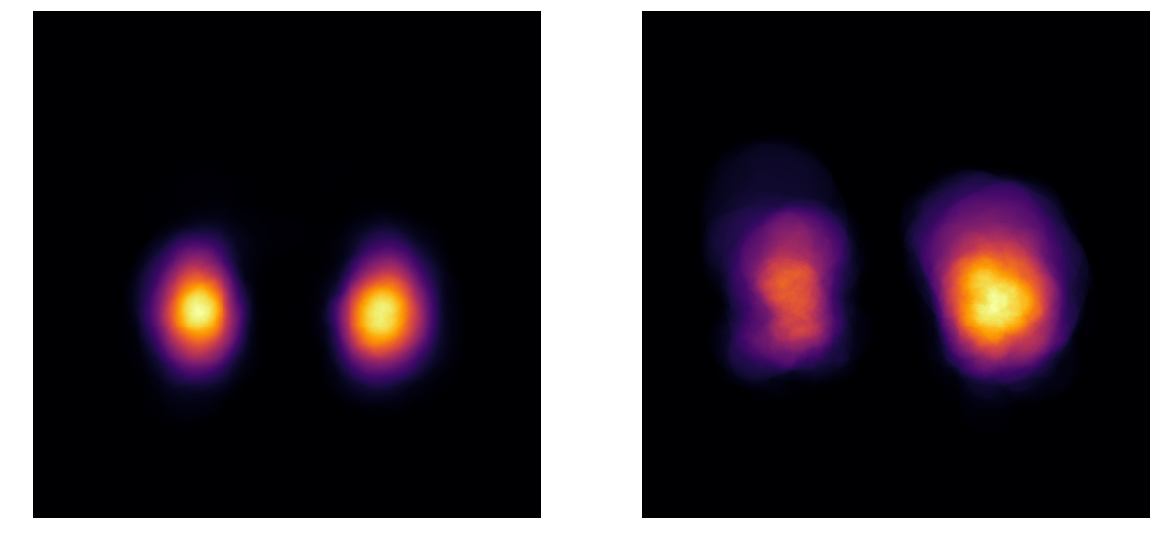

In [115]:
plt.subplot(1,2,1)
imshow(mean_kidney_mask, cmap='inferno')
plt.subplot(1,2,2)
imshow(mean_tumor_mask, cmap='inferno')
plt.show()